## delzinga.ipynb

In [1]:
import requests
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def read_office_script(url):
    # Read in the script from 
    r = requests.get(url)
    txt = r.text

    txt = re.sub('<[^<]+?>', '', txt) # Remove HTML commands
    txt = txt.replace('\n', '') # Remove new lines
    txt = txt.replace('&quot;', '') # Remove quotation
    txt = re.split('[A-Z][\w]+\:\s', txt)[1:] # Split on character indicators (e.g. Michael), drop everything before first line
    txt[-1] = re.split('[/\t]{2,}', txt[-1])[0] # The last line will contain the footer information. Scrape that off.
    lines = [re.sub('\[.+\]', '', t) for t in txt] # Remove actions from lines
    words = sum([re.split('\s+', line) for line in lines], []) # Break down into words
    words = [re.sub('[\., \/, \\, \,, \#, \!, \?, \$, \%, \^, \&, \*, \;, \:, \_]', '', w) for w in words] # Remove punctuation
    words = [w.lower() for w in words if w != ''] # Remove empty lines and put everything in lowercase
    
    c = Counter(words); N = len(c)
    freq_df = pd.DataFrame({'freq': [c for c in c.values()], 'rel. frequency': [c/N for c in c.values()], 'word': c.keys()})
    
    return freq_df, len(words)

In [3]:
def read_kims_script(url):
    # Read in the script from 
    r = requests.get(url)
    txt = r.text

    txt = re.sub('<[^<]+?>', '', txt) # Remove HTML commands
    txt = txt.replace('&quot;', '') # Remove quotation
    txt = re.split('[/\t, /\n]{2,}', txt)[29:-36] # Remove header and footer
    words = sum([re.split('\s+', t) for t in txt], []) # Break down into words
    words = [re.sub('[\., \/, \\, \,, \#, \!, \?, \$, \%, \^, \&, \*, \;, \:, \_]', '', w) for w in words] # Remove punctuation
    words = [w.lower() for w in words if w != ''] # Remove empty lines and put everything in lowercase

    c = Counter(words); N = len(c)
    freq_df = pd.DataFrame({'freq': [c for c in c.values()],'rel. frequency': [c/N for c in c.values()], 'word': c.keys()})

    return freq_df, len(words)

In [4]:
office_olympics_url = 'https://transcripts.foreverdreaming.org/viewtopic.php?f=574&t=25310&sid=ffd6c6b775557d91bb3a93d335ea083a'
office_koi_url = 'https://transcripts.foreverdreaming.org/viewtopic.php?f=574&t=25408'
office_olympics_df, num_words_olympics = read_office_script(office_olympics_url)
office_koi_df, num_words_koi = read_office_script(office_koi_url)

kim_parking_pass_url = 'https://transcripts.foreverdreaming.org/viewtopic.php?f=741&t=41626'
kim_df, num_words_kim = read_kims_script(kim_parking_pass_url)

## Part 1
Comapring word frequencies between two works of a single author - here I am using two scripts from the TV show, "The Office"

From the 2x2 plots and the scatter plot, we can make a few conclusions. 

    1. Largely speaking, the words chosen, and their frequency, is similar between the two episodes. This is a qualitatively demonstrated through the barcharts, distribution of word frequency, while also qualitatively shown as the linear correlation coefficient between the frequency of words in both episodes is close to 1. 
    2. The relative frequency of a few words awere marginally different between the episodes, and one of the words "was" particularly stands out. This word, being past tense, makes sense to appear more in the koi episode as the focal point of the episode is about an event that occured before the show. 

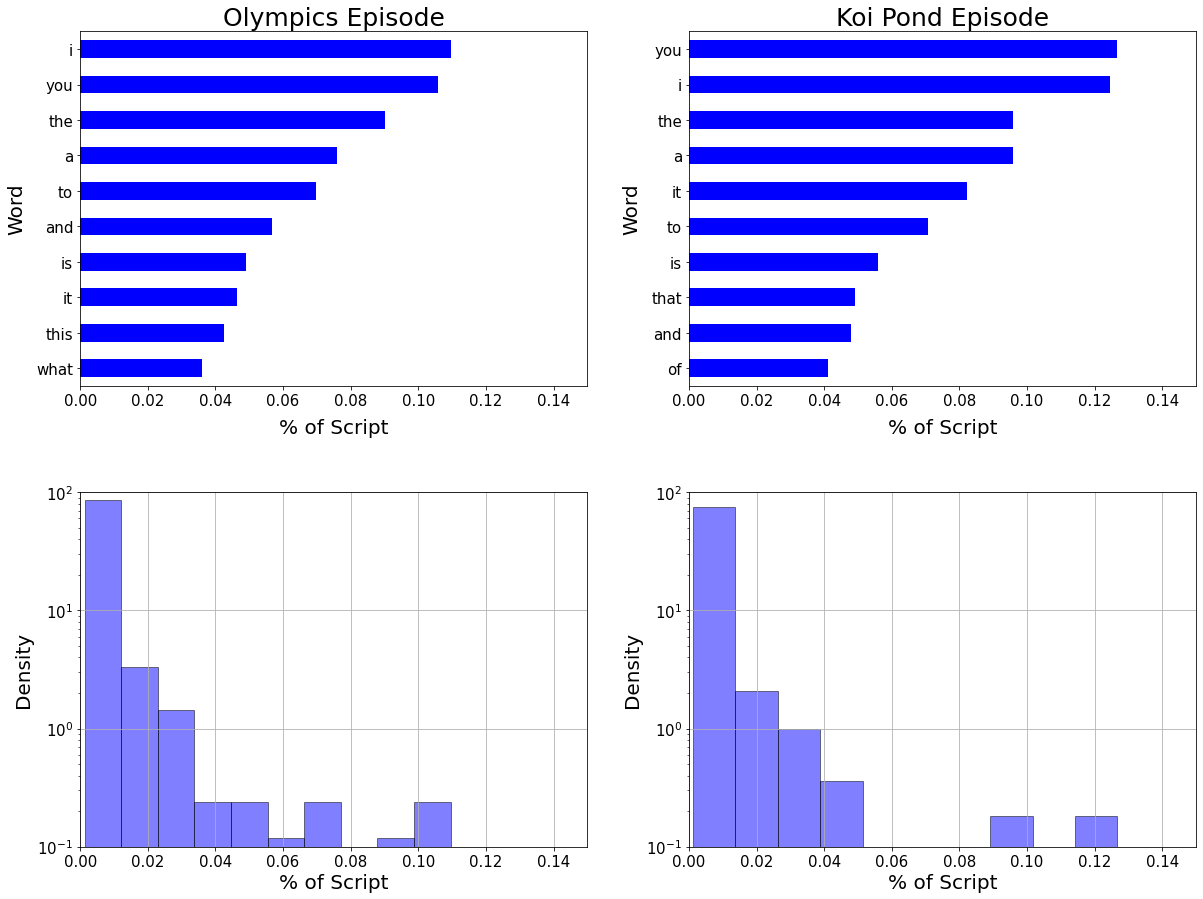

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

office_olympics_df.sort_values(by='rel. frequency', ascending=False)[:10].plot.barh(
    ax=axes[0, 0], x='word', y='rel. frequency', color='blue', legend=False)
office_olympics_df['rel. frequency'].hist(ax = axes[1, 0], color='blue', edgecolor='black', density=True, alpha=0.5)

office_koi_df.sort_values(by='rel. frequency', ascending=False)[:10].plot.barh(
    ax=axes[0, 1], x='word', y='rel. frequency', color='blue', legend=False)
office_koi_df['rel. frequency'].hist(ax = axes[1, 1], color='blue', edgecolor='black', density=True, alpha=0.5)

axes[0, 0].invert_yaxis(); axes[0, 1].invert_yaxis()
axes[1, 0].set_yscale('log'); axes[1, 1].set_yscale('log')
axes[0, 0].set_xlim(0, 0.15); axes[0, 1].set_xlim(0, 0.15)
axes[1, 0].set_xlim(0, 0.15); axes[1, 1].set_xlim(0, 0.15)
axes[1, 0].set_ylim(0.1, 100); axes[1, 1].set_ylim(0.1, 100)

axes[0, 0].set_xlabel('% of Script', fontsize=20, labelpad=10); axes[0, 1].set_xlabel('% of Script', fontsize=20, labelpad=10)
axes[0, 0].set_ylabel('Word', fontsize=20, labelpad=10); axes[0, 1].set_ylabel('Word', fontsize=20, labelpad=10)
axes[1, 0].set_xlabel('% of Script', fontsize=20); axes[1, 1].set_xlabel('% of Script', fontsize=20)
axes[1, 0].set_ylabel('Density', fontsize=20); axes[1, 1].set_ylabel('Density', fontsize=20)

for ax in axes.flatten():
    ax.tick_params(axis='both', labelsize=15)
    
axes[0, 0].set_title('Olympics Episode', fontsize=25)
axes[0, 1].set_title('Koi Pond Episode', fontsize=25)

fig.subplots_adjust(hspace=0.3)

0.8805944180504438


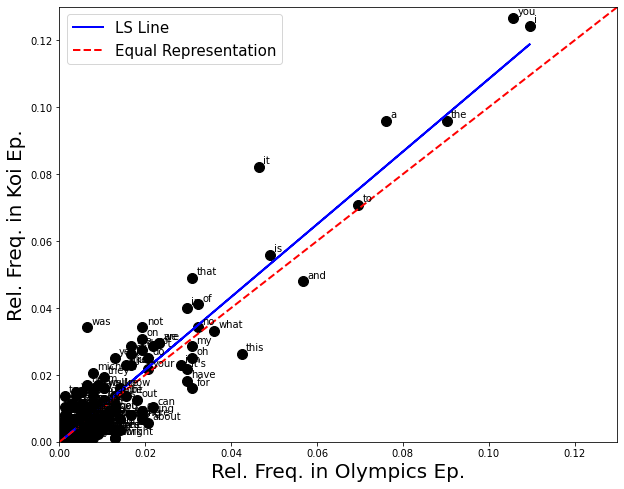

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
office_merge_df = office_olympics_df.merge(office_koi_df, on='word', how='inner')
office_merge_df['avg_freq'] = (office_merge_df['rel. frequency_x'] + office_merge_df['rel. frequency_y'])/2

office_merge_df.plot.scatter(x='rel. frequency_x', y='rel. frequency_y', s=100, ax=ax, c='k')
ax.set_xlabel('Rel. Freq. in Olympics Ep.', fontsize=20)
ax.set_ylabel('Rel. Freq. in Koi Ep.', fontsize=20)

top_df = office_merge_df.sort_values(by='avg_freq', ascending=False)[:200]
for i, txt in enumerate(top_df.word):
    ax.annotate(txt, (top_df.iloc[i]['rel. frequency_x'] + 0.001, top_df.iloc[i]['rel. frequency_y']+ 0.001))
    
m, b = np.polyfit(office_merge_df['rel. frequency_x'], office_merge_df['rel. frequency_y'], 1)
yhat = m*office_merge_df['rel. frequency_x'] + b
ax.plot(office_merge_df['rel. frequency_x'], yhat, 'b-', linewidth=2, label='LS Line');
R2 = (np.corrcoef(office_merge_df['rel. frequency_x'], office_merge_df['rel. frequency_y'])**2)[0,1]
print(R2)

ax.set_xlim(0, 0.13)
ax.set_ylim(0, 0.13)
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Equal Representation', transform=ax.transAxes);
ax.legend(fontsize=15);

### Parts 2 & 3
Comapring word frequencies between two works of from different authors - here I am using the pooled words from two TV episodes from the TV show, "The Office", and an episode from the TV show, "Kim's Convience"

From the 2x2 plots and the scatter plot, we can make a few conclusions. 

    1. Largely speaking, the words chosen, and their frequency, is similar between the two shows, however, the difference is more pronounced than when comparing two episodes from the same show. This is a qualitatively demonstrated through the barcharts, distribution of word frequency, while also qualitatively shown as the linear correlation coefficient between the frequency of words in both shows is close to 1 but less than before. 
    2. The relative frequency of a few words awere marginally different between the episodes. One noticeable trend is that articles such as "a" and "the" were more common in The Office compared to Kim's. This makes sense as the premise of Kim's is an immigrant Korean family who have moved to Canada, and the Korean language doesn't have an overt article system, thus, native speakers (such as those in Kim's) use articles less than native English speakers in The Office.
    
I also inspected the most common words in each show that don't appear in the other, and it turned out to be mostly character names, which seems to be expected. 

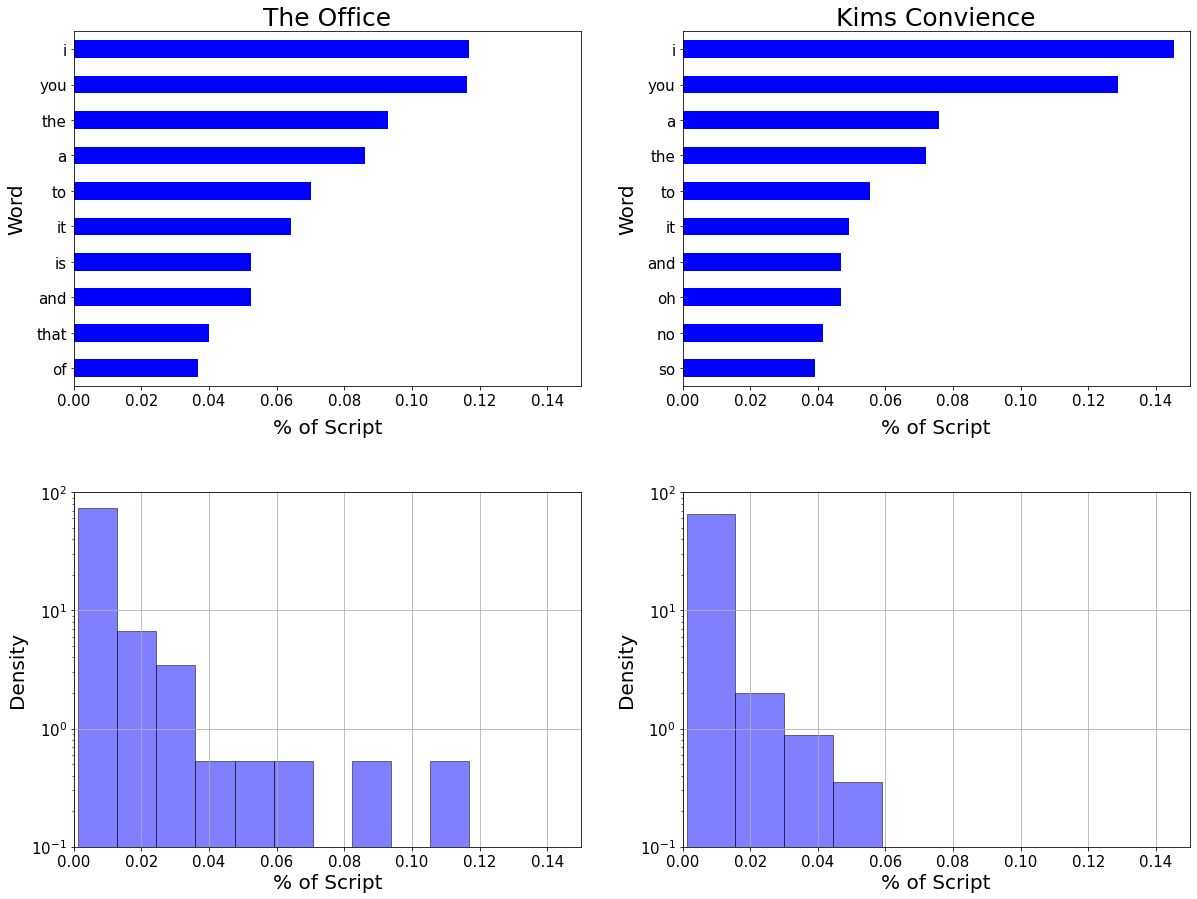

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

office_merge_df.sort_values(by='avg_freq', ascending=False)[:10].plot.barh(
    ax=axes[0, 0], x='word', y='avg_freq', color='blue', legend=False)
office_merge_df['avg_freq'].hist(ax = axes[1, 0], color='blue', edgecolor='black', density=True, alpha=0.5)

kim_df.sort_values(by='rel. frequency', ascending=False)[:10].plot.barh(
    ax=axes[0, 1], x='word', y='rel. frequency', color='blue', legend=False)
kim_df['rel. frequency'].hist(ax = axes[1, 1], color='blue', edgecolor='black', density=True, alpha=0.5)

axes[0, 0].invert_yaxis(); axes[0, 1].invert_yaxis()
axes[1, 0].set_yscale('log'); axes[1, 1].set_yscale('log')
axes[0, 0].set_xlim(0, 0.15); axes[0, 1].set_xlim(0, 0.15)
axes[1, 0].set_xlim(0, 0.15); axes[1, 1].set_xlim(0, 0.15)
axes[1, 0].set_ylim(0.1, 100); axes[1, 1].set_ylim(0.1, 100)

axes[0, 0].set_xlabel('% of Script', fontsize=20, labelpad=10); axes[0, 1].set_xlabel('% of Script', fontsize=20, labelpad=10)
axes[0, 0].set_ylabel('Word', fontsize=20, labelpad=10); axes[0, 1].set_ylabel('Word', fontsize=20, labelpad=10)
axes[1, 0].set_xlabel('% of Script', fontsize=20); axes[1, 1].set_xlabel('% of Script', fontsize=20)
axes[1, 0].set_ylabel('Density', fontsize=20); axes[1, 1].set_ylabel('Density', fontsize=20)

for ax in axes.flatten():
    ax.tick_params(axis='both', labelsize=15)

axes[0, 0].set_title('The Office', fontsize=25)
axes[0, 1].set_title('Kim''s Convience', fontsize=25)

fig.subplots_adjust(hspace=0.3)

0.8357274523234859


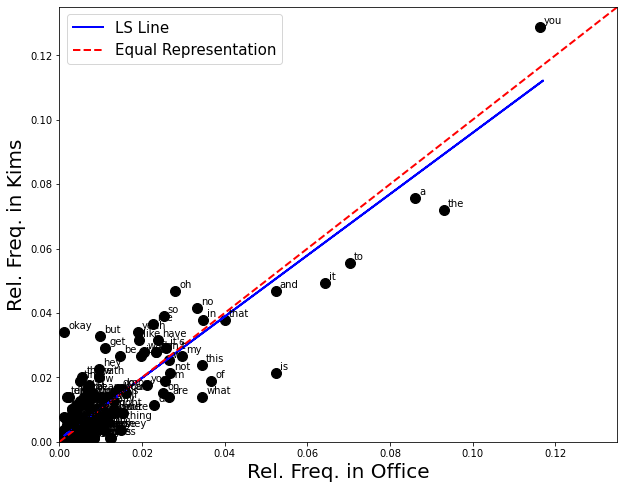

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
comapre_df = office_merge_df.merge(kim_df, on='word', how='inner')
comapre_df['avg_freq_comp'] = (comapre_df['avg_freq'] + comapre_df['rel. frequency'])/2

comapre_df.plot.scatter(x='avg_freq', y='rel. frequency', s=100, ax=ax, c='k')
ax.set_xlabel('Rel. Freq. in Office', fontsize=20)
ax.set_ylabel('Rel. Freq. in Kim''s', fontsize=20)

top_df = comapre_df.sort_values(by='avg_freq_comp', ascending=False)[:200]
for i, txt in enumerate(top_df.word):
    ax.annotate(txt, (top_df.iloc[i]['avg_freq'] + 0.001, top_df.iloc[i]['rel. frequency']+ 0.001))
    
m, b = np.polyfit(comapre_df['avg_freq'], comapre_df['rel. frequency'], 1)
yhat = m*comapre_df['avg_freq'] + b
ax.plot(comapre_df['avg_freq'], yhat, 'b-', linewidth=2, label='LS Line');
R2 = (np.corrcoef(comapre_df['avg_freq'], comapre_df['rel. frequency'])**2)[0,1]
print(R2)

ax.set_xlim(0, 0.135)
ax.set_ylim(0, 0.135)
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Equal Representation', transform=ax.transAxes);
ax.legend(fontsize=15);

In [40]:
kim_df[~kim_df['word'].isin(office_merge_df['word'].values)].sort_values(by='rel. frequency', ascending=False).head()

,freq,rel. frequency,word
362,12,0.015152,janet
283,7,0.008838,gonna
245,7,0.008838,parking
95,6,0.007576,back
250,6,0.007576,pass


In [43]:
office_merge_df[~office_merge_df['word'].isin(kim_df['word'].values)].sort_values(by='avg_freq', ascending=False).head()

,freq_x,rel. frequency_x,word,freq_y,rel. frequency_y,avg_freq
44,13,0.016753,ok,23,0.026256,0.021504
48,6,0.007732,michael,18,0.020548,0.014140
40,15,0.019330,going,7,0.007991,0.013660
64,7,0.009021,jim,15,0.017123,0.013072
271,4,0.005155,fun,13,0.014840,0.009997


### Extra Credit
Here I tested if the word "the" appears more in Kim's than it does in The Office. The null hypothesis is that the proportion of times "the" appears in The Office is less than the proportion of times "the" appears in Kim's Convience. This one-tailed z-test has a critical value around 1.65, our test statistic is greater, causing us to reject the null hypothesis, and accept the alternative. 

Thus, it appears that the word "the" appears significantly differently between Kim's and The Office, appearing more in The Office than Kim's. 

In [9]:
office_row = comapre_df[comapre_df['word'] == 'the']
n_office = num_words_koi + num_words_olympics
p_office = ((office_row.freq_x + office_row.freq_y)/n_office).values

n_kims = num_words_kim
p_kims = (kim_df[kim_df['word'] == 'the'].freq / n_kims).values

phat = (n_office*p_office + n_kims*p_kims) / (n_office + n_kims)

z = (p_office - p_kims) / (np.sqrt(phat*(1-phat)*(1/n_office + 1/n_kims)))
print(z)

[1.71248637]
